In [1]:
import mediapipe as mp
import numpy as np
import cv2
import math
import pandas as pd
import time
import os 
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

In [3]:
facemesh =  mp.solutions.face_mesh
face = facemesh.FaceMesh(
    static_image_mode=False, 
    min_tracking_confidence=0.5, 
    min_detection_confidence=0.5
    )
draw = mp.solutions.drawing_utils

In [4]:
def putText(frame, val, x, y, unity=""):
    if len(unity) == 0:
        cv2.putText(frame, f'{val}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    else:
        cv2.putText(frame, f'{val:.3f} {unity}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                
def getTargettedLandmark():
    targetted_landmark = []
    targetted_landmark.append(chosen_left_eye_idxs)
    targetted_landmark.append(chosen_right_eye_idxs)
    return targetted_landmark   

def drawText(frame, val, x, w, y, h):
    cv2.putText(
        frame, text= str(f'p{val}'), org=(int(x * w), int(y * h)),
        fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(0,255,0),
        thickness=3, lineType=cv2.LINE_AA
    )
    
def eucDist(point1, point2):
    return math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)

def eyeAspectRatio(right_eye, left_eye):
    right_eye = (eucDist(right_eye[2], right_eye[5]) + eucDist(right_eye[4], right_eye[3]))/(2*eucDist(right_eye[0], right_eye[1]))
    left_eye = (eucDist(left_eye[4], left_eye[3]) + eucDist(left_eye[5], left_eye[2]))/(2*eucDist(left_eye[1], left_eye[0]))
    return right_eye, left_eye

def eyeAnalysis(right_eye, left_eye):
    thresh_ear = 0.29
    eye_status = None
    avgEAR = (left_eye + right_eye) / 2
    if(right_eye < thresh_ear and left_eye < thresh_ear):
        # ear_msg = f'! Drowsiness Detected ! - EAR Score : {str(avgEAR)}'
        # print(ear_msg)
        eye_status = 'Mata Tertutup'
    else: 
        eye_status = 'Mata Terbuka'
    return eye_status

In [5]:
def get_image_samples(directory, sample_size=5):
    all_files = os.listdir(directory)

    image_files = [f for f in all_files if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    if len(image_files) < sample_size:
        raise ValueError(f"Not enough images to sample. Found {len(image_files)} images, but need {sample_size}.")
    
    sampled_images = random.sample(image_files, sample_size)
    loaded_images = [cv2.imread(os.path.join(directory, img)) for img in sampled_images]
    loaded_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in loaded_images]
    
    return loaded_images

def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    plt.show()

In [6]:
dataset_dir = './dataset/'

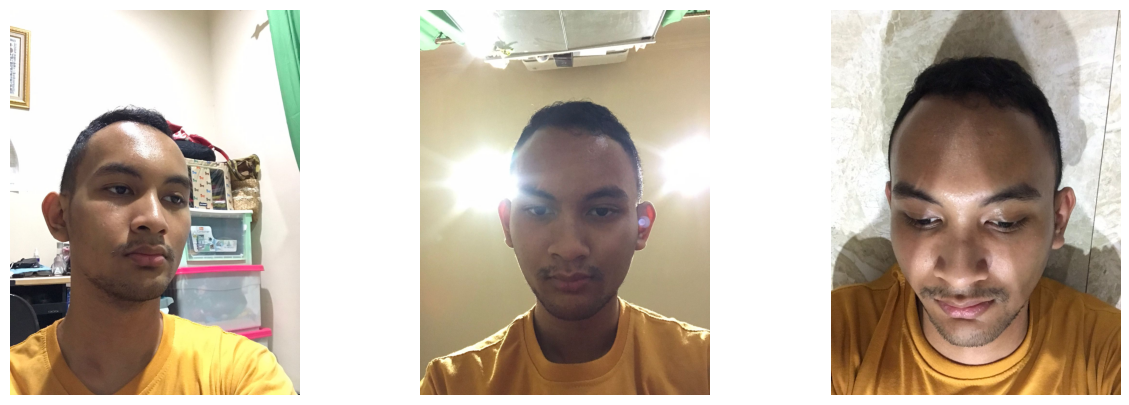

In [7]:
sampled_images = get_image_samples(f'{dataset_dir}Internal/Mata/Terbuka', 3)
display_images(sampled_images)

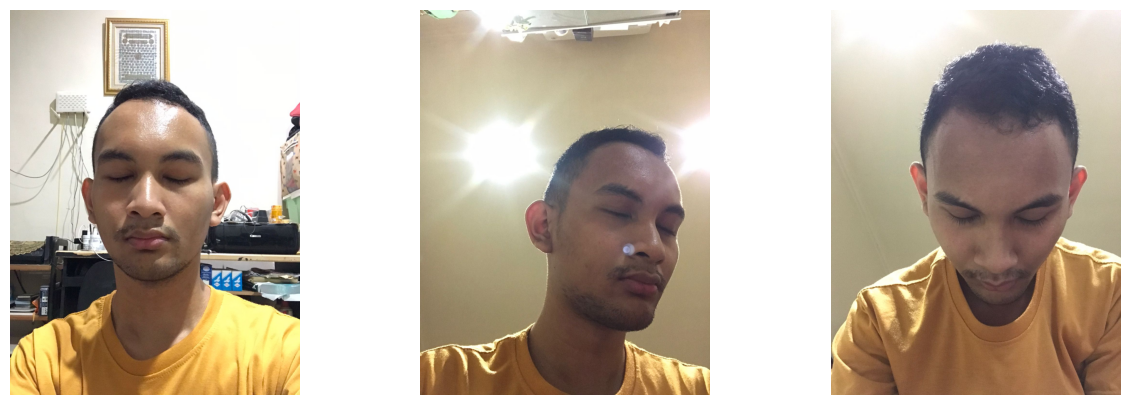

In [8]:
sampled_images = get_image_samples(f'{dataset_dir}Internal/Mata/Tertutup', 3)
display_images(sampled_images)

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


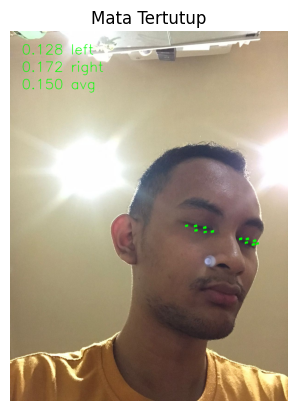

In [9]:
image = None
image = cv2.cvtColor(sampled_images[1], cv2.COLOR_BGR2RGB)
img_h, img_w, _ = image.shape
op = face.process(image)

if op.multi_face_landmarks:
    for pt in op.multi_face_landmarks:
        eye_store = [[], []]
        # thickness
        left_eye, right_eye, mouth, head = [1, 1, 1, 1]
        
        for no, point in enumerate(pt.landmark):
            if no in chosen_left_eye_idxs:
                drawText(image, left_eye, point.x, img_w, point.y, img_h)
                eye_store[0].append(point)
                left_eye += 1
            if no in chosen_right_eye_idxs:
                drawText(image, right_eye, point.x, img_w, point.y, img_h)
                eye_store[1].append(point)
                right_eye += 1
                
        if len(eye_store[0]) > 1:
            right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
            
        avg_ear = (right_eye+left_eye)/2 
        putText(image, left_eye, 50, 100, "left")
        putText(image, right_eye, 50, 175, "right")
        putText(image, avg_ear, 50, 250, "avg")
        
        eye_status = eyeAnalysis(right_eye, left_eye)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.axis('off')  # Hide axes for cleaner presentation
    plt.title(f'{eye_status}')
    plt.show()

In [10]:
def detect_drowsiness(image_path):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    op = face.process(image)

    if op.multi_face_landmarks:
        for pt in op.multi_face_landmarks:
            eye_store = [[], []]
            # thickness
            left_eye, right_eye, mouth, head = [1, 1, 1, 1]
            eye_status = None
            
            for no, point in enumerate(pt.landmark):
                if no in chosen_left_eye_idxs:
                    drawText(image, left_eye, point.x, img_w, point.y, img_h)
                    eye_store[0].append(point)
                    left_eye += 1
                if no in chosen_right_eye_idxs:
                    drawText(image, right_eye, point.x, img_w, point.y, img_h)
                    eye_store[1].append(point)
                    right_eye += 1
                    
            if len(eye_store[0]) > 1:
                right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
                
            avg_ear = (right_eye+left_eye)/2 
            putText(image, left_eye, 50, 100, "left")
            putText(image, right_eye, 50, 175, "right")
            putText(image, avg_ear, 50, 250, "avg")
            
            eye_status = eyeAnalysis(right_eye, left_eye)
        
        saved_image = image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            cv2.imwrite('tes.jpg', saved_image)
        except:
            print('image not saved')
        plt.imshow(image)
        plt.axis('off')  # Hide axes for cleaner presentation
        plt.title(f'{eye_status}')
        plt.show()

# Check Recheck Dataset

In [11]:
def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    
    return file_count

In [12]:
print('Open Eye: ', count_files_in_directory(f'{dataset_dir}/Terbuka'))
print('Close Eye: ', count_files_in_directory(f'{dataset_dir}/Tertutup'))

Open Eye:  0
Close Eye:  0


In [13]:
detect_drowsiness('closed_eye_1896-jpg_face_1_jpg.rf.a0fbbb81d52ee8ed51701b6b16d6e0b1.jpg')

In [14]:
# detect_drowsiness('20130529_02_Driv_152_f .jpg')

In [15]:
# detect_drowsiness('20130529_01_Driv_179_ll.jpg')

# Testing Flow

In [16]:
origin_paths = []
detect_paths = []
image_names = []
left_eyes = []
right_eyes = []
avg_eyes = []
truths = []
detected = []

In [17]:
def detect_drowsiness(image_path):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    print(img_h, img_w)
    op = face.process(image)

    if op.multi_face_landmarks:
        print('landmark detected')
        for pt in op.multi_face_landmarks:
            eye_store = [[], []]
            # thickness
            left_eye, right_eye, mouth, head = [1, 1, 1, 1]
            eye_status = None
            
            for no, point in enumerate(pt.landmark):
                if no in chosen_left_eye_idxs:
                    drawText(image, left_eye, point.x, img_w, point.y, img_h)
                    eye_store[0].append(point)
                    left_eye += 1
                if no in chosen_right_eye_idxs:
                    drawText(image, right_eye, point.x, img_w, point.y, img_h)
                    eye_store[1].append(point)
                    right_eye += 1
                    
            if len(eye_store[0]) > 1:
                right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
                
            avg_ear = (right_eye+left_eye)/2 
            putText(image, left_eye, 50, 100, "left")
            putText(image, right_eye, 50, 175, "right")
            putText(image, avg_ear, 50, 250, "avg")
            
            eye_status = eyeAnalysis(right_eye, left_eye)

        # detect_path = f'./detect/Mata/Terbuka/tes.jpg'
        # cv2.imwrite(f'{detect_path}', image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return right_eye, left_eye, avg_ear, eye_status, image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        plt.imshow(image)
        plt.axis('off')  # Hide axes for cleaner presentation
        plt.title(f'{eye_status}')
        plt.show()
    else:
        print('No Face Detected')

In [18]:
print('Open Eye: ', count_files_in_directory(f'testing/Mata/Terbuka'))
print('Close Eye: ', count_files_in_directory(f'testing/Mata/Tertutup'))

Open Eye:  277
Close Eye:  283


1. Combine Dataset [done]
2. Iterate Dataset
3. Predict
4. Save Image after Predict
5. Store Data
6. Testing Report

# Build Testing

In [19]:
_,_,_,_,p = detect_drowsiness("C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/testing/Mata/Terbuka/0002.jpg".replace('\\', '/'))
p.shape
image = Image.fromarray(p)
image.save('c.jpg')

218 178
landmark detected


In [20]:
'./detect/Mata/Terbuka'

'./detect/Mata/Terbuka'

In [21]:
def list_files_and_directories(root_dir):
    i = 0
    for root, dirs, files in os.walk(root_dir):
        # print(f"Root Directory: {root}")
        # for dir_name in dirs:
        #     print(f"Subdirectory: {os.path.join(root, dir_name)}")
        #     dir_
        for file_name in files:
            label = root.split('\\')[-1]
            file_path = os.path.join(root, file_name).replace('\\', '/')
            # print(file_path) 
            # right_eye, left_eye, avg_ear, eye_status, img = detect_drowsiness(file_path)
            try:
                right_eye, left_eye, avg_ear, eye_status, img = detect_drowsiness(file_path)
                # print(right_eye, left_eye, avg_ear, eye_status)
                right_eyes.append(right_eye)
                left_eyes.append(left_eye)
                avg_eyes.append(avg_ear)
                origin_paths.append(file_path)
                image_names.append(file_name)
                truths.append(label)
                detected.append(eye_status.split()[-1])

                try:
                    # './detect/Mata/Terbuka'
                    print(label)
                    detect_path = f'./detect/Mata/{label}/{file_name}'
                    print(detect_path)
                    image = Image.fromarray(img)
                    image.save(f'{detect_path}.jpg')
                    # cv2.imwrite(f'{detect_path}.jpg', img)
                except FileNotFoundError:
                    print('File path not found, image not saved')
                except Exception as e:
                    print(f'Error occurred: {str(e)}')
                    print('Image not saved')
                detect_paths.append(detect_path)
            except:
                err_val = None
                right_eyes.append(err_val)
                left_eyes.append(err_val)
                avg_eyes.append(err_val)
                origin_paths.append(err_val)
                image_names.append(err_val)
                truths.append(err_val)
                detected.append(err_val)
                print(f'cannot detect image: {i}')
                i += 1
                detect_paths.append(err_val)
            
            # print(f"File: {os.path.join(root, file_name)}")

origin_paths = []
detect_paths = []
image_names = []
left_eyes = []
right_eyes = []
avg_eyes = []
truths = []
detected = []


input_dir = './testing'
if os.path.isdir(input_dir):
    list_files_and_directories(input_dir)
else:
    print("Path yang dimasukkan bukan direktori yang valid.")


218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0001.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0002.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0003.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0004.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0005.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0006.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0007.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0008.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0009.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0010.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0012.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0013.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0014.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0015.jpg
218 178
landmark detected
Terbuka
./detect/Mata/Terbuka/0016.jpg
218 178
landmark detected

In [22]:
print(origin_paths[-1])
print(detect_paths[-1])
print(image_names[-1])
print(left_eyes[-1])
print(right_eyes[-1])
print(avg_eyes[-1])
print(truths[-1])
print(detected[-1])

./testing/Mata/Tertutup/0561.jpg
./detect/Mata/Tertutup/0561.jpg
0561.jpg
0.2758707316346105
0.2625469198735405
0.2692088257540755
Tertutup
Tertutup


In [23]:
print(len(origin_paths))
print(len(detect_paths))
print(len(image_names))
print(len(left_eyes))
print(len(right_eyes))
print(len(avg_eyes))
print(len(truths))
print(len(detected))

560
560
560
560
560
560
560
560


In [24]:
df = pd.DataFrame({
    'origin_path': origin_paths,
    'detect_path': detect_paths,
    'image_names': origin_paths,
    'left_eye': left_eyes,
    'right_eye': right_eyes,
    'avg_eye': avg_eyes,
    'truth': truths,
    'detected': detected
})

df.head()

,origin_path,detect_path,image_names,left_eye,right_eye,avg_eye,truth,detected
0,./testing/Mata/Terbuka/0001.jpg,./detect/Mata/Terbuka/0001.jpg,./testing/Mata/Terbuka/0001.jpg,0.275692,0.348745,0.312218,Terbuka,Terbuka
1,./testing/Mata/Terbuka/0002.jpg,./detect/Mata/Terbuka/0002.jpg,./testing/Mata/Terbuka/0002.jpg,0.257408,0.334117,0.295763,Terbuka,Terbuka
2,./testing/Mata/Terbuka/0003.jpg,./detect/Mata/Terbuka/0003.jpg,./testing/Mata/Terbuka/0003.jpg,0.254613,0.220641,0.237627,Terbuka,Tertutup
3,./testing/Mata/Terbuka/0004.jpg,./detect/Mata/Terbuka/0004.jpg,./testing/Mata/Terbuka/0004.jpg,0.294866,0.236832,0.265849,Terbuka,Terbuka
4,./testing/Mata/Terbuka/0005.jpg,./detect/Mata/Terbuka/0005.jpg,./testing/Mata/Terbuka/0005.jpg,0.291555,0.193012,0.242283,Terbuka,Terbuka


In [26]:
df.isnull().sum()

origin_path    36
detect_path    36
image_names    36
left_eye       36
right_eye      36
avg_eye        36
truth          36
detected       36
dtype: int64

In [28]:
df.to_csv('result-detection.csv', index=False)